## PCB Defect Detection: Object Detection Evaluation (V3)

Dataset Source: https://universe.roboflow.com/srtimagedefectdetection-wuadb/pcb-defect-detection-hdqc8

##### Install Necessary Libraries Not Already Installed

In [1]:
%pip install transformers tensorboard timm coco-eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 32.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 6.3 MB/s eta 0:00:00
  Created wheel for coco-eval: filename=coco_eval-0.0.4-py3-none-any.whl size=5036 sha256=5bd9ca25f756babbad507bfea92c7b5de7c61211529746126ab1651a6b367bbc
  Stored in directory: /root/.cache/pip/wheels/51/73/56/423d59979be1af3ec949e6524af7dd5127ba2cbe4b30981afb
Successfully built coco-eval


##### Import Necessary Libraries

In [2]:
import os, sys, json

import numpy as np
from tqdm.notebook import tqdm

import torch
import torchvision

from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import DetrImageProcessor, AutoModelForObjectDetection

from PIL import Image, ImageDraw

import transformers

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### Access to HuggingFace Hub

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

##### Display Versions of Relevant Libraries

In [4]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Torch Vision:".rjust(15), torchvision.__version__)

        Python: 3.9.16
         NumPy: 1.22.4
  Transformers: 4.27.4
         Torch: 1.13.1+cu116
  Torch Vision: 0.14.1+cu116


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### COCO Detection Class

In [6]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, processor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in COCO format for both PIL image & target
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        image_id = self.ids[idx]
        target = {'image_id': image_id, 
                  'annotations': target}

        encoding = self.processor(images=img, 
                                  annotations=target, 
                                  return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # Remove batch dimension
        target = encoding["labels"][0] # Remove batch dimension

        return pixel_values, target

#### Ingest Data

In [7]:
parent_dir = "/content/drive/MyDrive/PCB Defect Detection"

img_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

eval_ds = CocoDetection(img_folder=os.path.join(parent_dir, 'test'), 
                        ann_file=os.path.join(parent_dir, 'test', "_annotations.coco.json"), 
                        processor=img_processor)

/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=2.21s)
creating index...
index created!


In [8]:
print(f"The testing dataset has {len(eval_ds)} samples in it.")

The testing dataset has 288 samples in it.


In [9]:
pixel_values, target = eval_ds[2]
print(pixel_values.shape)
print(target.keys())

torch.Size([3, 800, 800])
dict_keys(['size', 'image_id', 'class_labels', 'boxes', 'area', 'iscrowd', 'orig_size'])


/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


##### Visualize Example

Image n°39


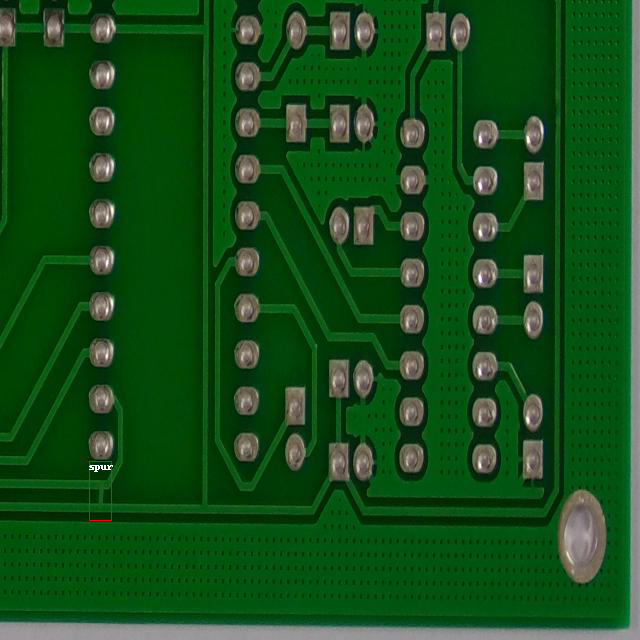

In [10]:
categories = ["missing hole", 
              "mouse bite", 
              "open circuit", 
              "short", 
              "spur", 
              "spurious copper"]

NUM_LABELS = len(categories)

id2label = {k: v for k, v in enumerate(categories)}
label2id = {v: k for k, v in id2label.items()}

image_ids = eval_ds.coco.getImgIds()

# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = eval_ds.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(parent_dir, "test", image['file_name']))

annotations = eval_ds.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

#### Define Data Collator

In [11]:
def collate_function(batch):
  pixel_values = [item[0] for item in batch]
  encoding = img_processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

#### Define Test DataLoader

In [12]:
test_dataloader = DataLoader(eval_ds, collate_fn=collate_function, batch_size=2)

#### Verify First Batch

In [13]:
batch = next(iter(test_dataloader))
batch.keys()
     
batch['pixel_values'].shape
     
batch['pixel_mask'].shape

torch.Size([2, 800, 800])

#### Install COCO Evaluation Package

In [14]:
! git clone https://github.com/facebookresearch/detr.git
%cd detr

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 263 (delta 0), reused 1 (delta 0), pack-reused 260
Receiving objects: 100% (263/263), 12.88 MiB | 9.15 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/detr


#### Initialize COCOEvaluator

In [15]:
import sys; sys.path.insert(0, "/content/detr/detr")

from datasets.coco_eval import CocoEvaluator
from datasets import get_coco_api_from_dataset

# This just calls coco attribute
base_ds = get_coco_api_from_dataset(eval_ds)
iou_types = ['bbox']

# Initialize evaluator w/ reference
coco_evaluator = CocoEvaluator(base_ds, iou_types) 

#### Basic Values/Constants

In [16]:
MODEL_NAME = "DunnBC22/detr-resnet-50-PCB_Defect_Detection_v3"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Instantiate Model

In [17]:
model = AutoModelForObjectDetection.from_pretrained(MODEL_NAME).to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


#### Calculate Metrics

In [18]:
for idx, batch in enumerate(tqdm(test_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    # forward pass
    outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    
    # Convert outputs to COCO Format
    results = img_processor.post_process(outputs, orig_target_sizes)
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

  0%|          | 0/144 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:1266: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


#### Display Metrics

In [19]:
coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.51s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

### Notes & Other Takeaways
****
- The toughest part of training both object detection and image segmentation models is that they require better hardware than what I have.

****

#### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-2005-12872, author = {Nicolas Carion and Francisco Massa and Gabriel Synnaeve and Nicolas Usunier and Alexander Kirillov and Sergey Zagoruyko}, title = {End-to-End Object Detection with Transformers}, journal = {CoRR}, volume = {abs/2005.12872}, year = {2020}, url = {https://arxiv.org/abs/2005.12872}, archivePrefix = {arXiv}, eprint = {2005.12872}, timestamp = {Thu, 28 May 2020 17:38:09 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2005-12872.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset
    > @misc{ pcb-defect-detection-hdqc8_dataset, title = { PCB defect detection Dataset }, type = { Open Source Dataset }, author = { SRTImageDefectDetection }, howpublished = { \url{ https://universe.roboflow.com/srtimagedefectdetection-wuadb/pcb-defect-detection-hdqc8 } }, url = { https://universe.roboflow.com/srtimagedefectdetection-wuadb/pcb-defect-detection-hdqc8 }, journal = { Roboflow Universe }, publisher = { Roboflow }, year = { 2022 }, month = { sep }, note = { visited on 2023-07-30 },}